<font face="微软雅黑" size=3 color=#A52A2A > 
On the basis of mentioned preprocessing,this script shows how to rotate 3D medical image
    
In this case I will show how to rotate a skull

In [1]:
from xml.etree import ElementTree as ET
import matplotlib.pyplot as plt
import os
import SimpleITK as sitk
import pydicom
import numpy as np
import cv2
import glob
from tqdm import tqdm
import scipy.ndimage
import math
import scipy

<font face="微软雅黑" size=2 color=1 > 
Here is the explanation about what is Frankfort plane,whaw I will show afterwards is to make it parallel to horizontal plane by rotation

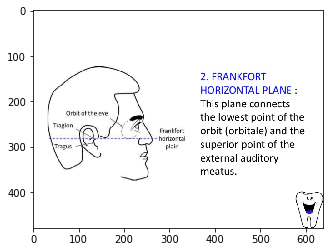

In [18]:
img=cv2.imread('fp.jpg')
plt.imshow(img)
plt.show()

<font face="微软雅黑" size=2 color=1 > 
load information of location of landmark for skull first

In [8]:
#read xml file
tree = ET.parse('DCM1\OB17-ABU-FUR full_landmarks.xml')
root = tree.getroot()
childs = root.getchildren()

#collect landmarks
points = []
for child0 in childs:
    point = {}
    for child00 in child0.getchildren():
        point[child00.tag] = child00.text
    points.append(point)
print('Number of landmark for skull is:',len(points))

#extract coordinates
co=[]
for i in range(len(points)):
    print([points[i]['{urn:materialise}Name'],points[i]['{urn:materialise}Coordinate']])
    c=points[i]['{urn:materialise}Coordinate']
    list=c.split(' ')
    for j in range(3):
        list[j]=float(list[j])
    co.append(list)

D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  after removing the cwd from sys.path.
D:\ANACONDA\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  # Remove the CWD from sys.path while we load stuff.


Number of landmark for skull is: 33
['11A', '-0.873573 -99.4015 9.33487']
['11E', '-2.32594 -107.689 -12.1015']
['16O', '-19.6903 -84.9152 -9.67292']
['21A', '5.7224 -99.1103 9.94992']
['21E', '5.77961 -107.963 -12.1105']
['26O', '24.5584 -85.2722 -9.56667']
['31A', '3.32642 -90.7505 -30.2012']
['31E', '3.91793 -101.593 -11.5564']
['36O', '21.6512 -83.373 -9.77347']
['41A', '-1.05373 -90.2149 -30.7161']
['41E', '-1.33234 -101.548 -11.8757']
['46O', '-20.1161 -82.9967 -10.0419']
['A', '2.15153 -103.975 13.0001']
['ANS', '2.12029 -107.695 22.0824']
['B', '1.67753 -94.1177 -34.7168']
['Gnathion', '1.987 -92.4131 -51.8697']
['Gonion Left', '42.9568 -42.1859 -27.1924']
['Gonion Right', '-38.6626 -41.0948 -27.9599']
['Infraorbitale Foramen Left', '19.5091 -92.7767 38.2713']
['Infraorbitale Foramen Right', '-17.1661 -93.6198 37.772']
['Internal Acoustic Foramen Left', '28.7417 -5.42708 32.9831']
['Internal Acoustic Foramen Right', '-25.5872 -5.32342 30.0383']
['Mental Foramen Left', '22.383 -

<font face="微软雅黑" size=4 color=2 > 
How to Rotate?

<font face="微软雅黑" size=2 color=2 > 
Establish anatomical frame->calculate rotation matrix->get Bryant Sequence->Rotate in x,y,z order

In [10]:
from scipy.linalg import*
from sympy import*

#extract three points for Frankfort plane__Porion Left,Porion Right,Orbitale left
pl=np.array(co[30])
pr=np.array(co[31])
ol=np.array(co[26])

#create local frame
x=pl-pr
x_norm=x/np.sqrt(np.sum(x**2))
origin=pl-x*(pl[0]-ol[0])/(pl[0]-pr[0])
y=origin-ol
y_norm=y/np.sqrt(np.sum(y**2))
z_norm=np.cross(x_norm,y_norm)

#schmidt orthognalization
L=[Matrix(x_norm), Matrix(y_norm),Matrix(z_norm)]
r=GramSchmidt(L,True)
rotation=np.array(r)

# in Radian
a = math.atan(-rotation[1,2]/rotation[2,2]) 
b = math.asin(rotation[0,2]) ;
c = math.atan(-rotation[0,1]/rotation[0,0])

#  in °
a = a * 180 / 3.1416 
b = b * 180 / 3.1416
c = c * 180 / 3.1416

#Bryant Sequence
bs=[a,b,c]

#rotate image in x,y,z order
image_r = scipy.ndimage.interpolation.rotate(image, bs[0], mode='nearest', axes=(1, 2), reshape=True)
image_r = scipy.ndimage.interpolation.rotate(image_r, bs[1], mode='nearest', axes=(0, 2), reshape=True)
image_r= scipy.ndimage.interpolation.rotate(image_r, bs[2], mode='nearest', axes=(0, 1), reshape=True)

<font face="微软雅黑" size=3 color=#A52A2A > 
Rotation Comparison  
    
(but as the orientation of patients is good,so there is no notable difference)

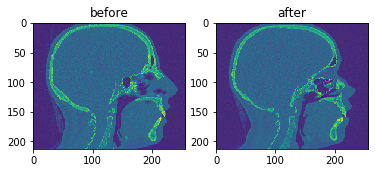

In [15]:
plt.figure()
lb=image[:,:,128]
lb=np.flip(lb)
la=image[:,:,140]
la=np.flip(la)
plt.subplot(1,2,1)
plt.imshow(lb)
plt.title('before')
plt.subplot(1,2,2)
plt.imshow(la)
plt.title('after')
plt.show()